In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy import corrcoef


In [2]:
mm_df = pd.read_csv('data/paperid_media_metrics.tsv', sep='\t')
cn_df = pd.read_csv('data/paperid_num_citations.txt', sep='\t', names=['id', 'citation'])
meta_df = pd.read_csv('data/paperid_metadata.tsv', sep='\t', names=['id', 'title', 'authors', 'mail_host', 'field', 'abstract'])

In [3]:
# drop non-numerical rows
mm_df['mendeley'] = pd.to_numeric(mm_df['mendeley'], errors='coerce')
mm_df.dropna(axis=0, how='any', inplace=True)

cn_df['citation'] = pd.to_numeric(cn_df['citation'], errors='coerce')
cn_df.dropna(axis=0, how='any', inplace=True)

# merge the two tables
mm_df = pd.merge(mm_df, cn_df, left_on='paperid', right_on='id')
mm_df.drop('id', axis=1, inplace=True)
metric_fields = list(sorted(set(mm_df.columns) - {'paperid'}))

## Correlattion between altimtric score and other metrics

Interesting fact: 

citation number is negatively correlated with the altimetric score

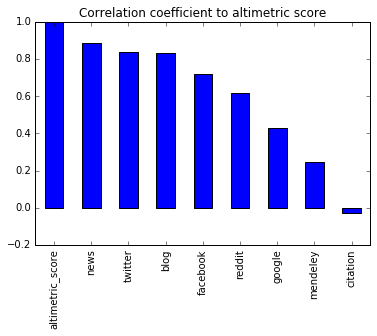

In [4]:
data = mm_df[metric_fields].as_matrix().T
corrmat = pd.DataFrame(corrcoef(data), columns=metric_fields, index=metric_fields)
corrmat['altimetric_score'].sort_values(ascending=False).plot(kind='bar', title='Correlation coefficient to altimetric score')



In [5]:
# some preprocessing for regression model's input

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

meta_df['authors'] = meta_df['authors'].map(lambda s: ' '.join(s.split(';')))

meta_df = pd.merge(meta_df, mm_df, left_on='id', right_on='paperid')
meta_df.drop('paperid', axis=1, inplace=True)
meta_df.fillna(value='', axis=0, inplace=True)
meta_df['field'] = meta_df['field'].map(lambda s: s.replace(',', '_'))
meta_df['authors'] = meta_df['authors'].map(lambda s: s.replace('.', '__'))

In [6]:
# split train/test data
train = meta_df.iloc[:30000]
test = meta_df.iloc[30000:]

In [7]:
# convert text to sparse matrices
col2tfidf = {}
text_columns = ['title', 'authors', 'abstract', 'mail_host', 'field']
train_mats = []
test_mats = []
for col in tqdm(text_columns):
    if col in {'main_host', 'field'}:
        tfidf = TfidfVectorizer(use_idf=False, tokenizer=None)
    else:
        tfidf = TfidfVectorizer(stop_words='english')
    train_mats.append(tfidf.fit_transform(train[col].values))
    test_mats.append(tfidf.transform(test[col].values))
    col2tfidf[col] = tfidf

100%|██████████| 5/5 [00:11<00:00,  1.74s/it]


In [8]:
# concatenate different feature matrices
from scipy.sparse import hstack, vstack
train_X = hstack(train_mats)
test_X = hstack(test_mats)

## Correlation between target variable and different features

The higher the correlation coefficient, the more relevant the feature is to the target variable

Modify the value of `target_variable` to other variables if necessary

In [9]:
from scipy.stats import pearsonr
from joblib import Parallel, delayed

target_variable = 'altimetric_score'  # modify this variable if you want to check other target variables

col2tf = {}
text_columns = ['title', 'authors', 'abstract', 'mail_host', 'field']
mats = []
for col in tqdm(text_columns):
    if col in {'main_host', 'field'}:
        tf = TfidfVectorizer(use_idf=False, tokenizer=None)
    else:
        tf = TfidfVectorizer(stop_words='english', use_idf=False)  # idf is disabled
    mats.append(tf.fit_transform(meta_df[col].values))
    col2tf[col] = tf
    


100%|██████████| 5/5 [00:09<00:00,  1.49s/it]


In [10]:
# feature_X = train_mats[1]
feature_X = hstack(mats).tocsc()
Y = meta_df[target_variable].values
coefs = Parallel(n_jobs=-1)(delayed(pearsonr)(feature_X[:, i].toarray()[:, 0], Y)
                            for i in range(feature_X.shape[1]))
coefs = np.array(coefs)[:, 0]

In [12]:
indx = []
# for col in text_columns:
for col in text_columns:
    t = col2tf[col] 
    inds = list(t.vocabulary_.values())
    id2word = {v: k for k, v in t.vocabulary_.items()}
    indx += ['{}({})'.format(id2word[i], col) for i in range(np.min(inds), np.max(inds)+1)]    

In [13]:
print(len(indx))
print(len(coefs))

311036
311036


In [14]:
top_k = 15
feature_coef = pd.DataFrame({'name': indx[:len(coefs)], 'coef': coefs})
print('top-{} positively correlated features'.format(top_k))
feature_coef.sort_values(by='coef', ascending=False).head(top_k)

top-15 positively correlated features


,coef,name
32959,0.405646,adam_d___i___kramer(authors)
102464,0.405646,jeffrey_t___hancock(authors)
99820,0.405646,jamie_e___guillory(authors)
219745,0.405646,bmj(abstract)
241991,0.405646,fowler(abstract)
224564,0.405646,christakis(abstract)
210176,0.405646,a2338(abstract)
308609,0.405646,fb(mail_host)
264302,0.285506,moods(abstract)
239785,0.268247,facebook(abstract)


In [16]:
print('top-{} negatively correlated features'.format(top_k))
feature_coef.sort_values(by='coef', ascending=True).head(top_k)

top-15 negatively correlated features


,coef,name
281325,-0.073860,protein(abstract)
223294,-0.061963,cells(abstract)
223281,-0.059588,cell(abstract)
310988,-0.058271,biochemistry(field)
218859,-0.057216,binding(abstract)
281343,-0.050941,proteins(abstract)
23448,-0.048280,protein(title)
236674,-0.047098,em(abstract)
239368,-0.045342,expression(abstract)
234291,-0.042178,domain(abstract)


## metric value vs item number

Comment: many metrics follow power-law distribution

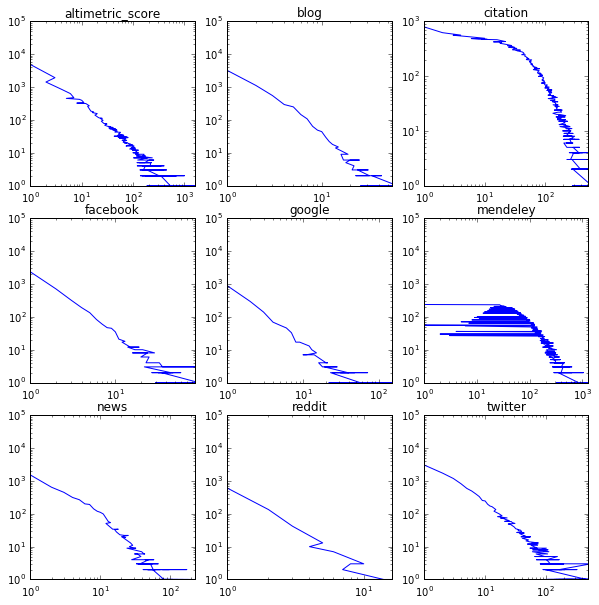

In [17]:
# for each metric, 
# plot the value vs frequency in log-log scale
# most of them seem to be power-law
fig = plt.figure(figsize=(10, 10))

for i, f in enumerate(metric_fields):
    fig.add_subplot(3, 3, i+1)
    freq = train[f].value_counts()
    ax = freq.plot(logx=True, logy=True, title=f)


## predicting metric number

[Train/test score](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score) should be [-1, 1]. The higher the better. 

Comment:

- Lasso performs badly
- RandomForrest model performs better: the more estimators, the better score
- RandomForrest suffers from overfitting

In [18]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [19]:
target_variable = 'altimetric_score'

scaler = MinMaxScaler()
train_Y = scaler.fit_transform(train[target_variable].values[:, None])[:, 0]
test_Y = scaler.transform(test[target_variable].values[:, None])[:, 0]

models = [Lasso(alpha=0.1),
          RandomForestRegressor(n_estimators=4, n_jobs=-1),
          RandomForestRegressor(n_estimators=8, n_jobs=-1),
          RandomForestRegressor(n_estimators=16, n_jobs=-1),
          RandomForestRegressor(n_estimators=32, n_jobs=-1)]
for clf in models:
    clf.fit(train_X, train_Y)
    print(clf)
    print('train score: {}'.format(clf.score(train_X, train_Y)))
    print('test score: {}'.format(clf.score(test_X, test_Y)))

/home/cloud-user/code/social-media-exposure/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
train score: 0.0
test score: -2.1051533503513298e-05
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=4, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
train score: 0.8013039528225415
test score: 0.01986774121706436
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=8, n_jobs=-1, oob_score=False, random_state=None,
           verbose